In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from lib import DihedralAdherencePDB
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv
from scipy.stats import linregress
from lib import MultiWindowQuery

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

# Validation

In [ ]:
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]

In [ ]:
np.random.seed(42)
choices = np.random.choice(pdb_codes, 5, replace=False)

In [ ]:
from lib.modules import query_and_process_pdbmine
results = []
results_window = []
lens = []
np.random.seed(42)
choices = np.random.choice(pdb_codes, 5, replace=False)
for pdb_code in choices:
    da = MultiWindowQuery(pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR)
    idx = np.random.randint(1, len(da.queries))
    r, rw = query_and_process_pdbmine(da.queries[idx])
    results_window.append(rw)
    lens.append(len(da.sequence))

Results already exist
Structure exists: 'pdb/pdb4jse.ent' 
UniProt ID: P29476
Results already exist
Structure exists: 'pdb/pdb7kvk.ent' 
UniProt ID: P08684
Results already exist
Structure exists: 'pdb/pdb4f0z.ent' 
UniProt ID: Q08209
Results already exist
Structure exists: 'pdb/pdb3ihu.ent' 
UniProt ID: Q46SA5
Results already exist
Structure exists: 'pdb/pdb7jhk.ent' 
UniProt ID: Q9NY97


In [39]:
print(np.mean(lens), np.std(lens))
results_window = pd.concat(results_window)
print(results_window.shape)
results_window.to_csv('3mil_angles.csv', index=False)

374.6 87.40160181598505
(2973391, 8)


In [3]:
results_window = pd.read_csv('3mil_angles.csv')

In [4]:
results_window_g = results_window[maskg := (results_window.res == 'G')]
results_window_p = results_window[maskp := (results_window.res == 'P')]
results_window_all = results_window[~maskg & ~maskp]
results_window_g.shape, results_window_p.shape, results_window_all.shape

((174251, 8), (150246, 8), (2648894, 8))

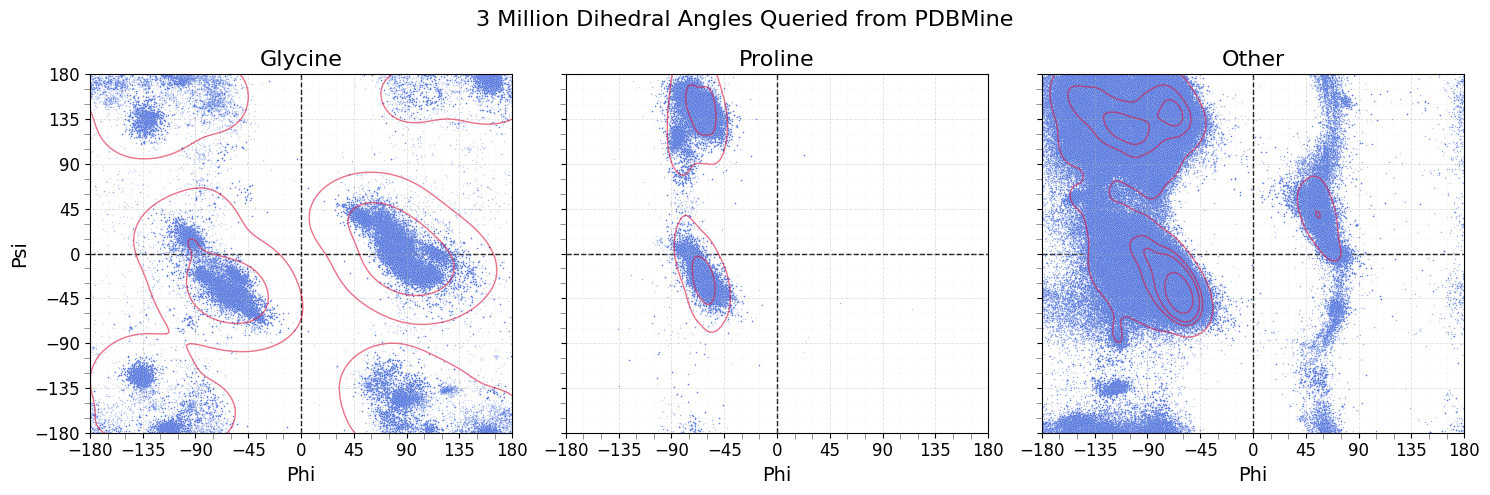

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for i,(df,ax) in enumerate(zip([results_window_g, results_window_p, results_window_all], axes)):
    # Scatter plot with better contrast and transparency
    sns.scatterplot(
        data=df,#.sample(1_000_000), 
        x='phi', y='psi', 
        s=1, ax=ax, 
        alpha=0.3, color='royalblue'
    )
    levels = 5 if i == 2 else 3
    sns.kdeplot(
        data=df.sample(len(df)//10),
        x='phi', y='psi', 
        levels=levels, color='crimson', 
        linewidths=1, alpha=0.6, ax=ax
    )

    # Set axis limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi', fontsize=14)
    ax.set_ylabel('Psi', fontsize=14)

    # Improve tick styling
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-180, 181, 45))
    ax.set_xticks(np.arange(-180, 181, 15), minor=True)
    ax.set_yticks(np.arange(-180, 181, 15), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', length=4, color='gray')

    # Improve grid styling
    ax.grid(True, linestyle="--", alpha=0.4, linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", alpha=0.2, linewidth=0.5)

    # Add reference lines
    ax.axhline(0, color='black', linewidth=1, linestyle='--', zorder=0)
    ax.axvline(0, color='black', linewidth=1, linestyle='--', zorder=0)

axes[0].set_title('Glycine', fontsize=16)
axes[1].set_title('Proline', fontsize=16)
axes[2].set_title('Other', fontsize=16)
plt.suptitle('3 Million Dihedral Angles Queried from PDBMine', fontsize=16)
plt.tight_layout()
plt.savefig('paper_plots/3mil_angles.pdf', dpi=300)

In [125]:
df.n_matches.sum()

186574282

In [134]:
167941800

167941800

# Global Search

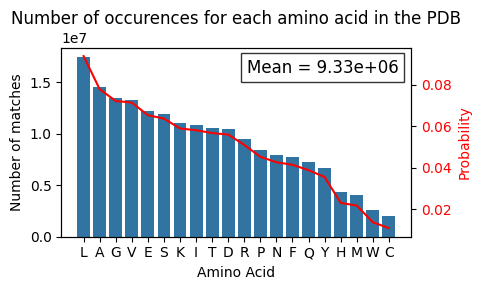

In [ ]:
k=1
df = pd.read_csv(f'data/win{k}.csv', keep_default_na=False)
df = df.sort_values('n_matches', ascending=False)
df['prob'] = df['n_matches'] / sum(df['n_matches'])

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=df, x='seq', y='n_matches', ax=ax)
ax.set_ylabel('Number of matches')
ax.set_xlabel('Amino Acid')
ax.set_title(f'Number of occurences for each amino acid in the PDB')
ax2 = ax.twinx()
sns.lineplot(data=df, x='seq', y='prob', ax=ax2, color='r')
ax2.set_ylabel('Probability', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax.text(0.53, 0.94, f'Mean = {df.n_matches.mean():.2e}',transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8))
# plt.show()

plt.tight_layout()
# plt.savefig('paper_plots/mq_win1.pdf', dpi=300)


In [ ]:
# Shen et al. "Probabilistic analysis of the frequencies of amino acid pairs within characterized protein sequences"
amino_acid_probs = {
    'A': 0.0777, 'C': 0.0157, 'D': 0.0530, 'E': 0.0656, 'F': 0.0405,
    'G': 0.0691, 'H': 0.0227, 'I': 0.0591, 'K': 0.0595, 'L': 0.0960,
    'M': 0.0238, 'N': 0.0427, 'P': 0.0469, 'Q': 0.0393, 'R': 0.0526,
    'S': 0.0694, 'T': 0.0550, 'V': 0.0667, 'W': 0.0118, 'Y': 0.0311
}
df2 = pd.DataFrame(amino_acid_probs.items(), columns=['seq', 'prob_shen'])

# Nacar "The Frequencies of Amino Acids in Secondary Structural Elements of Globular Proteins"
from lib.constants import AMINO_ACID_CODES
amino_acid_values = {
    'ALA': 8.3, 'ARG': 5.1, 'ASN': 4.3, 'ASP': 6.0, 'CYS': 1.4,
    'GLN': 3.7, 'GLU': 6.4, 'GLY': 7.3, 'HIS': 2.5, 'ILE': 5.5,
    'LEU': 9.2, 'LYS': 5.4, 'MET': 2.1, 'PHE': 4.2, 'PRO': 4.8,
    'SER': 6.1, 'THR': 5.6, 'TRP': 1.5, 'TYR': 3.6, 'VAL': 7.0
}
df3 = pd.DataFrame(amino_acid_values.items(), columns=['seq', 'prob_nacar'])
df3['seq'] = [AMINO_ACID_CODES[seq] for seq in df3['seq']]
df3['prob_nacar'] = df3['prob_nacar'] / 100

df = pd.read_csv('data/win1.csv')
df['prob'] = df['n_matches'] / df['n_matches'].sum()

df = df.merge(df2, on='seq').merge(df3, on='seq')

df = df.sort_values('n_matches', ascending=False)

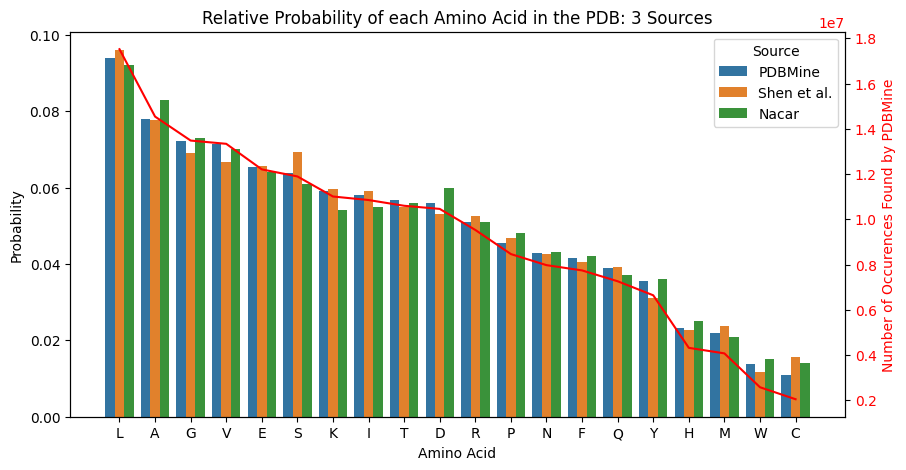

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
df = df.rename({'prob': 'PDBMine', 'prob_shen': 'Shen et al.', 'prob_nacar': 'Nacar'}, axis=1)
probs = df.melt(id_vars='seq', value_vars=['PDBMine', 'Shen et al.', 'Nacar'], var_name='Source', value_name='prob_value')
sns.barplot(probs, x='seq', y='prob_value', hue='Source', ax=ax)
ax.set_xlabel('Amino Acid')
ax.set_ylabel('Probability')
ax.set_title(f'Relative Probability of each Amino Acid in the PDB: 3 Sources')

ax2 = ax.twinx()
sns.lineplot(data=df, x='seq', y='n_matches', ax=ax2, color='r')
ax2.set_ylabel('Number of Occurences Found by PDBMine', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.savefig('paper_plots/monomers.pdf')

In [ ]:
df = pd.read_csv('data/win5.csv', keep_default_na=False)
f'{df.n_matches.mean():1.2e}', f'{df.n_matches.std():1.2e}', f'{df.n_matches.min():1.2e}', f'{df.n_matches.max():1.2e}'

('5.54e+01', '1.45e+02', '0.00e+00', '3.06e+04')

In [161]:
df.n_matches.sum()

179541505

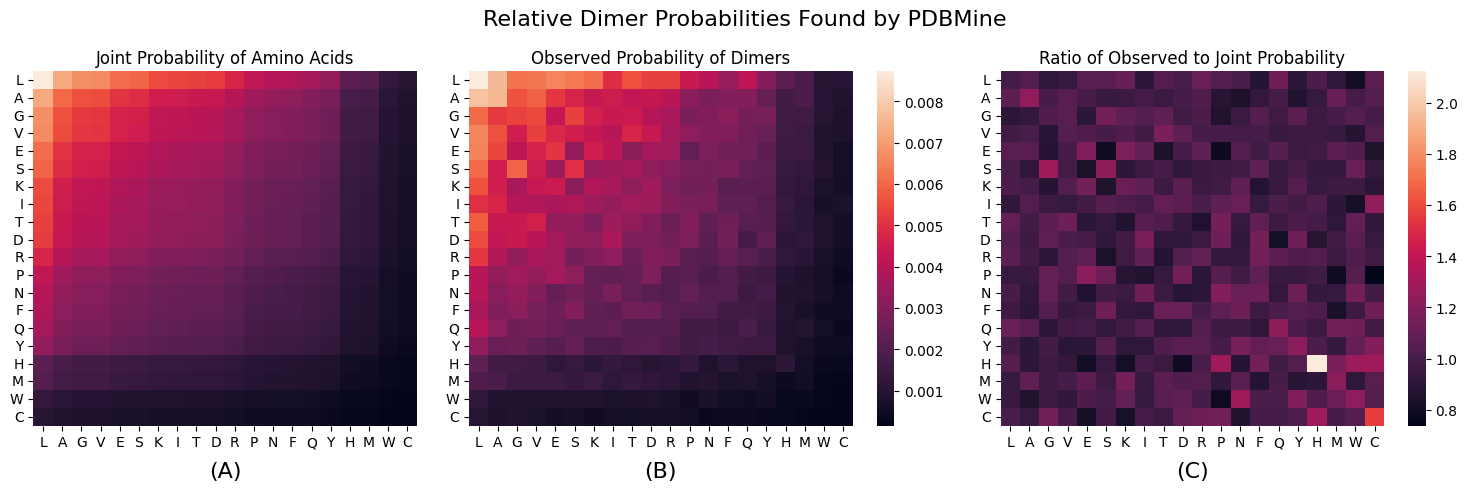

In [ ]:
import matplotlib.colors as mcolors

df1 = pd.read_csv('data/win1.csv', keep_default_na=False)
df2 = pd.read_csv('data/win2.csv' , keep_default_na=False)

df1['prob'] = df1['n_matches'] / sum(df1['n_matches'])
df1 = df1.sort_values('n_matches', ascending=False)
df2['prob'] = df2['n_matches'] / sum(df2['n_matches'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [0.8, 1, 1]})

joint_probs = np.outer(df1.prob, df1.prob)

probs = []
matches = []
seqs = df1.seq
for aa1 in seqs:
    p = []
    m = []
    for aa2 in seqs:
        p.append(df2.loc[df2.seq == aa1+aa2].prob.values[0])
        m.append(df2.loc[df2.seq == aa1+aa2].n_matches.values[0])
    probs.append(p)
    matches.append(m)
probs = np.array(probs)
matches = np.array(matches)

probs_ratio =  probs / joint_probs

sns.heatmap(joint_probs, ax=axes[0], cbar=False)
axes[0].set_title('Joint Probability of Amino Acids')
axes[0].set_xticks(np.arange(len(df1.seq))+0.5)
axes[0].set_xticklabels(df1.seq, rotation=0)
axes[0].set_yticks(np.arange(len(df1.seq))+0.5)
axes[0].set_yticklabels(df1.seq, rotation=0)
axes[0].text(0.5, -0.1, '(A)', transform=axes[0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center')

sns.heatmap(probs, ax=axes[1])
axes[1].set_title('Observed Probability of Dimers')
axes[1].set_xticks(np.arange(len(df1.seq))+0.5)
axes[1].set_xticklabels(seqs, rotation=0)
axes[1].set_yticks(np.arange(len(df1.seq))+0.5)
axes[1].set_yticklabels(df1.seq, rotation=0)
axes[1].text(0.5, -0.1, '(B)', transform=axes[1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center')

sns.heatmap(probs_ratio, ax=axes[2])
axes[2].set_title('Ratio of Observed to Joint Probability')
axes[2].set_xticks(np.arange(len(df1.seq))+0.5)
axes[2].set_xticklabels(seqs, rotation=0)
axes[2].set_yticks(np.arange(len(df1.seq))+0.5)
axes[2].set_yticklabels(df1.seq, rotation=0)
axes[2].text(0.5, -0.1, '(C)', transform=axes[2].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center')

plt.suptitle('Relative Dimer Probabilities Found by PDBMine', fontsize=16)
plt.tight_layout()
# plt.show()
# plt.savefig('paper_plots/dimer_probs.pdf', dpi=300)

1.0068343308815322 -1.708582720383019e-05
1.01236825235808 -1.54603154475997e-06
1.0197877948835485 -1.2367371802217864e-07
1.0280595225620341 -8.768600800636025e-09


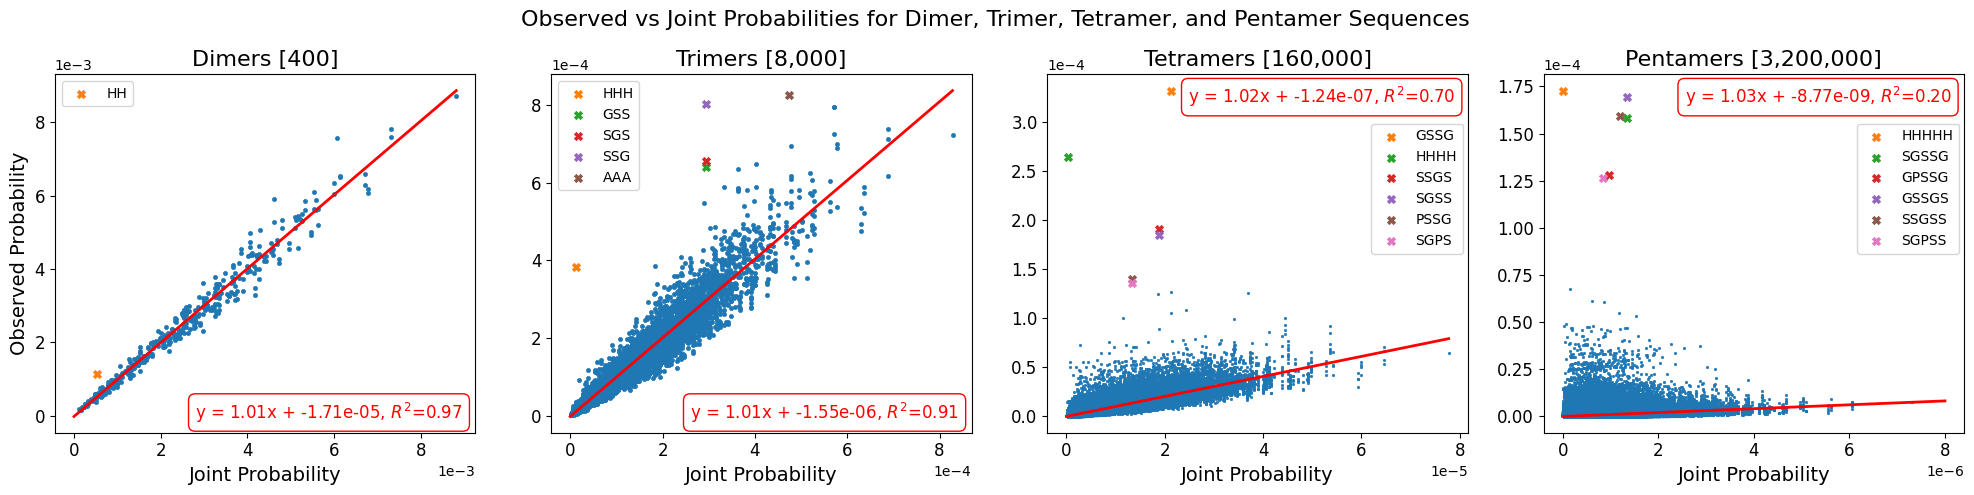

In [ ]:
df1 = pd.read_csv('data/win1.csv', keep_default_na=False)
df1['prob'] = df1['n_matches'] / sum(df1['n_matches'])
df1 = df1.sort_values('n_matches', ascending=False)

labels = ['Dimers', 'Trimers', 'Tetramers', 'Pentamers']
winsizes = [2,3,4,5]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax = axes[i]
    w = winsizes[i]
    df2 = pd.read_csv(f'data/win{w}.csv' , keep_default_na=False)    
    df2['prob'] = df2['n_matches'] / sum(df2['n_matches'])

    log_probs = np.log10(df1.set_index('seq').prob)
    # df2['log_prob'] = np.log10(df2.prob)
    df2['log_joint_prob'] = df2.seq.apply(lambda x: np.sum([log_probs[aa] for aa in x]))
    # df2['log_probs_ratio'] = df2.log_joint_prob - df2.log_prob
    # df2['probs_ratio'] = 10**df2.log_probs_ratio
    df2['joint_prob'] = 10**df2.log_joint_prob

    df2['seq_key'] = df2.seq.apply(lambda x: ''.join(sorted(x)))
    # df2 = df2.groupby('seq_key').mean(numeric_only=True).reset_index().rename(columns={'seq_key': 'seq'})

    # sns.scatterplot(data=df2[(df2.seq != 'HHHH') & (df2.seq != 'HHHHH')], x='joint_prob', y='prob', marker='.', ax=ax, edgecolor=None)

    if i > 1:
        sns.scatterplot(data=df2, x='joint_prob', y='prob', marker='.', ax=ax, edgecolor=None, s=15)
    else:
        sns.scatterplot(data=df2, x='joint_prob', y='prob', marker='.', ax=ax, edgecolor=None)
    regr = linregress(df2.joint_prob, df2.prob)
    print(regr.slope, regr.intercept)
    line = np.linspace(0, df2.joint_prob.max(), 100)
    if i == 3:
        line = np.linspace(0, 8e-6, 100)
    ax.plot(line, regr.intercept + regr.slope * line, color='red', lw=2)
    eq = f'y = {regr.slope:.02f}x + {regr.intercept:.02e}, ' + r'$R^2$' + f'={regr.rvalue**2:0.2f}'

    eq_loc = .97, .09
    if i == 0:
        sns.scatterplot(data=df2[df2.seq=='HH'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='HH')
        ax.set_ylabel('Observed Probability', fontsize=14)
        ax.legend(loc='upper left')
    if i == 1:
        sns.scatterplot(data=df2[df2.seq=='HHH'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='HHH')
        sns.scatterplot(data=df2[df2.seq=='GSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GSS')
        sns.scatterplot(data=df2[df2.seq=='SGS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SGS')
        sns.scatterplot(data=df2[df2.seq=='SSG'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SSG')
        sns.scatterplot(data=df2[df2.seq=='AAA'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='AAA')
        ax.set_ylabel('')
        ax.legend(loc='upper left')
    elif i == 2:
        # print(f'Tetramer: {df2.loc[df2.seq == "HHHH", ['joint_prob', 'prob']].values}')
        sns.scatterplot(data=df2[df2.seq=='GSSG'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GSSG')
        sns.scatterplot(data=df2[df2.seq=='HHHH'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='HHHH')
        sns.scatterplot(data=df2[df2.seq=='SSGS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SSGS')
        sns.scatterplot(data=df2[df2.seq=='SGSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SGSS')
        sns.scatterplot(data=df2[df2.seq=='PSSG'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='PSSG')
        sns.scatterplot(data=df2[df2.seq=='SGPS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SGPS')
        ax.set_ylabel('')
        eq_loc = .97, .97
        ax.legend(loc=(0.77, 0.5))

    elif i == 3:
        # print(f'Pentamer: {df2.loc[df2.seq == "HHHHH", ['joint_prob', 'prob']].values}')
        sns.scatterplot(data=df2[df2.seq=='HHHHH'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='HHHHH')
        sns.scatterplot(data=df2[df2.seq=='SGSSG'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SGSSG')
        sns.scatterplot(data=df2[df2.seq=='GPSSG'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GPSSG')
        sns.scatterplot(data=df2[df2.seq=='GSSGS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GSSGS')
        sns.scatterplot(data=df2[df2.seq=='SSGSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SSGSS')
        sns.scatterplot(data=df2[df2.seq=='SGPSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SGPSS')
        # ax.set_ylim(0,1.75e-4)
        # ax.set_xlim(0, 8e-6)
        # ax.set_xticks([0, 2e-6, 4e-6, 6e-6, 8e-6])
        ax.set_ylabel('')
        eq_loc = .97, .97
        ax.legend(loc=(0.745, 0.5))
    
    ax.text(*eq_loc, eq, transform=ax.transAxes, fontsize=12, color='red',
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))

    ax.set_title(labels[i] + f' [{20**(winsizes[i]):,}]', fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Joint Probability', fontsize=14)
    # if i == 2:
    #     break

plt.suptitle('Observed vs Joint Probabilities for Dimer, Trimer, Tetramer, and Pentamer Sequences', fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/di_tri_tetra_pentamers.png', dpi=300)
# plt.savefig('paper_plots/di_tri_tetra_pentamers.pdf', dpi=300)

# Contexualized Sequences

In [13]:
da = DihedralAdherence('T1030', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window')
da.load_results()

Initializing T1030 ...
casp_da/T1030_win4-5-6-7
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6


Initializing T1030 ...
casp_da/T1030_win4-5-6-7
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6


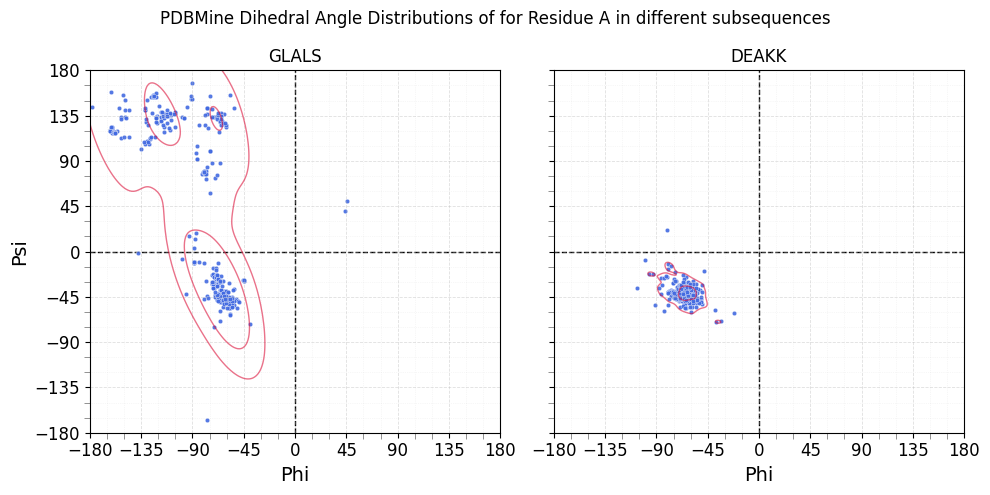

In [61]:
da = DihedralAdherence('T1030', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window')
da.load_results()
from lib.utils import get_phi_psi_dist
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for i, seq in enumerate(['KGLALSK', 'LDEAKKM']):
    phi_psi_dist,_ = get_phi_psi_dist([da.queries[1]], seq)
    seq = da.queries[1].get_subseq(seq)
    ax = axes[i]
    sns.scatterplot(
        data=phi_psi_dist,
        x='phi', y='psi', 
        s=10, ax=ax, 
        alpha=0.9, color='royalblue'
    )
    sns.kdeplot(
        data=phi_psi_dist,
        x='phi', y='psi', 
        levels=3, color='crimson', 
        linewidths=1, alpha=0.6, ax=ax
    )

    # Set axis limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi', fontsize=14)
    ax.set_ylabel('Psi', fontsize=14)

    # Improve tick styling
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-180, 181, 45))
    ax.set_xticks(np.arange(-180, 181, 15), minor=True)
    ax.set_yticks(np.arange(-180, 181, 15), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', length=4, color='gray')

    # Improve grid styling
    ax.grid(True, linestyle="--", alpha=0.4, linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", alpha=0.2, linewidth=0.5)

    # Add reference lines
    ax.axhline(0, color='black', linewidth=1, linestyle='--', zorder=0)
    ax.axvline(0, color='black', linewidth=1, linestyle='--', zorder=0)

    ax.set_title(seq)

plt.suptitle('PDBMine Dihedral Angle Distributions of for Residue A in different subsequences')
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/2_dihedral_dist.pdf', dpi=300)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_ramachandran(ax, z=0, alpha=0.6):
    # Define the shapes with given coordinates
    shapes = [
        (1, [(-156.5, 91.3), (-70.4, 91.3), (-54.7, 112.8), (-54.7, 173.2), (-136.9, 173.2), (-136.9, 155.8), (-156.5, 135.6), (-156.5, 91.3)]),
        (0, [(-180.0, 42.9), (-140.8, 16.1), (-86.0, 16.1), (-74.3, 45.6), (-74.3, 72.5), (-44.3, 102.0), (-44.3, 161.1), (-46.9, 179.9), (-180.0, 180.0)]),
        (0, [(-180.0, -34.9), (-164.3, -42.9), (-133.0, -42.9), (-109.4, -32.2), (-106.9, -21.4), (-44.3, -21.4), (-44.3, -71.1), (-180.0, -71.1)]),
        (1, [(-156.5, -60.4), (-54.7, -60.4), (-54.7, -40.2), (-100.4, -40.2), (-123.9, -51.0), (-156.5, -51.0), (-156.5, -60.4)]),
        (0, [(-180.0, -180.0), (-180.0, -163.8), (-75.6, -163.8), (-46.9, -180.0)]),
        (0, [(62.6, 14.7), (62.6, 96.7), (45.6, 79.2), (45.6, 26.8), (62.6, 14.7)])
    ]

    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Plot each shape
    for type, shape in shapes:
        if type == 0:
            polygon = patches.Polygon(shape, closed=True, edgecolor='black', facecolor='yellow', alpha=alpha, zorder=z-1)
        else:
            polygon = patches.Polygon(shape, closed=True, edgecolor='black', facecolor='red', alpha=alpha, zorder=z)
        ax.add_patch(polygon)

    ax.set_xticks(range(-180, 181, 60))
    ax.set_yticks(range(-180, 181, 60))

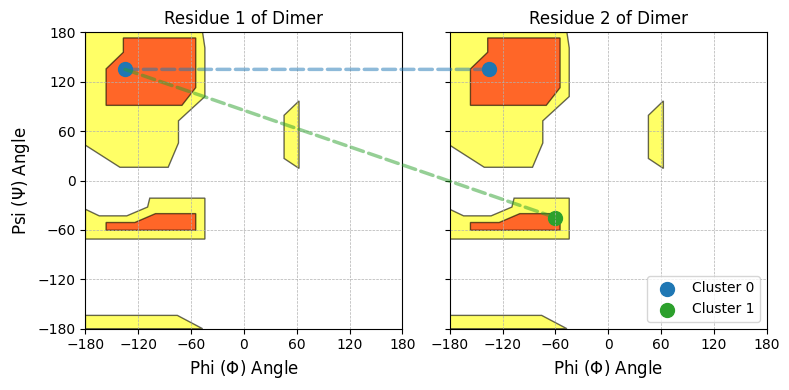

In [56]:
fig, axes = plt.subplots(1,2, figsize=(8, 4), sharey=True)

plot_ramachandran(axes[0], z=0, alpha=0.6)
axes[0].scatter(-135, 135, marker='o', color='tab:blue', s=100, label='Cluster 0')
axes[0].set_ylabel(r"Psi ($\Psi$) Angle", fontsize=12)
axes[0].set_xlabel(r"Phi ($\Phi$) Angle", fontsize=12)
axes[0].set_title('Residue 1 of Dimer', fontsize=12)

plot_ramachandran(axes[1], z=0, alpha=0.6)
axes[1].scatter(-135, 135, marker='o', color='tab:blue', s=100, label='Cluster 0')
axes[1].scatter(-60, -45, marker='o', color='tab:green', s=100, label='Cluster 1')
axes[1].set_ylabel('')
axes[1].set_xlabel(r"Phi ($\Phi$) Angle", fontsize=12)
axes[1].legend(loc='lower right')
axes[1].set_title('Residue 2 of Dimer', fontsize=12)

con = ConnectionPatch(
    xyA=(-135, 135), 
    xyB=(-135, 135), 
    coordsA="data", coordsB="data", 
    axesA=axes[0], axesB=axes[1], 
    color='tab:blue', lw=2.5, linestyle='--', alpha=0.5
)
fig.add_artist(con)
con = ConnectionPatch(
    xyA=(-135, 135), 
    xyB=(-60, -45), 
    coordsA="data", coordsB="data", 
    axesA=axes[0], axesB=axes[1], 
    color='tab:green', lw=2.5, linestyle='--', alpha=0.5,
)
fig.add_artist(con)


plt.tight_layout()

plt.savefig('paper_plots/high_dim_clusters.pdf', dpi=300)

In [ ]:
from lib.utils import get_phi_psi_dist

da = DihedralAdherencePDB('2RJ7', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window', kdews=[0,1,0,0])
da.load_results()
phi_psi_dist, results = get_phi_psi_dist(da.queries, da.seqs[10])
xrays = da.xray_phi_psi.loc[da.xray_phi_psi['seq_ctxt'] == da.seqs[10], ['phi', 'psi']]

Results already exist
Structure exists: 'pdb/pdb2rj7.ent' 
UniProt ID: P16442


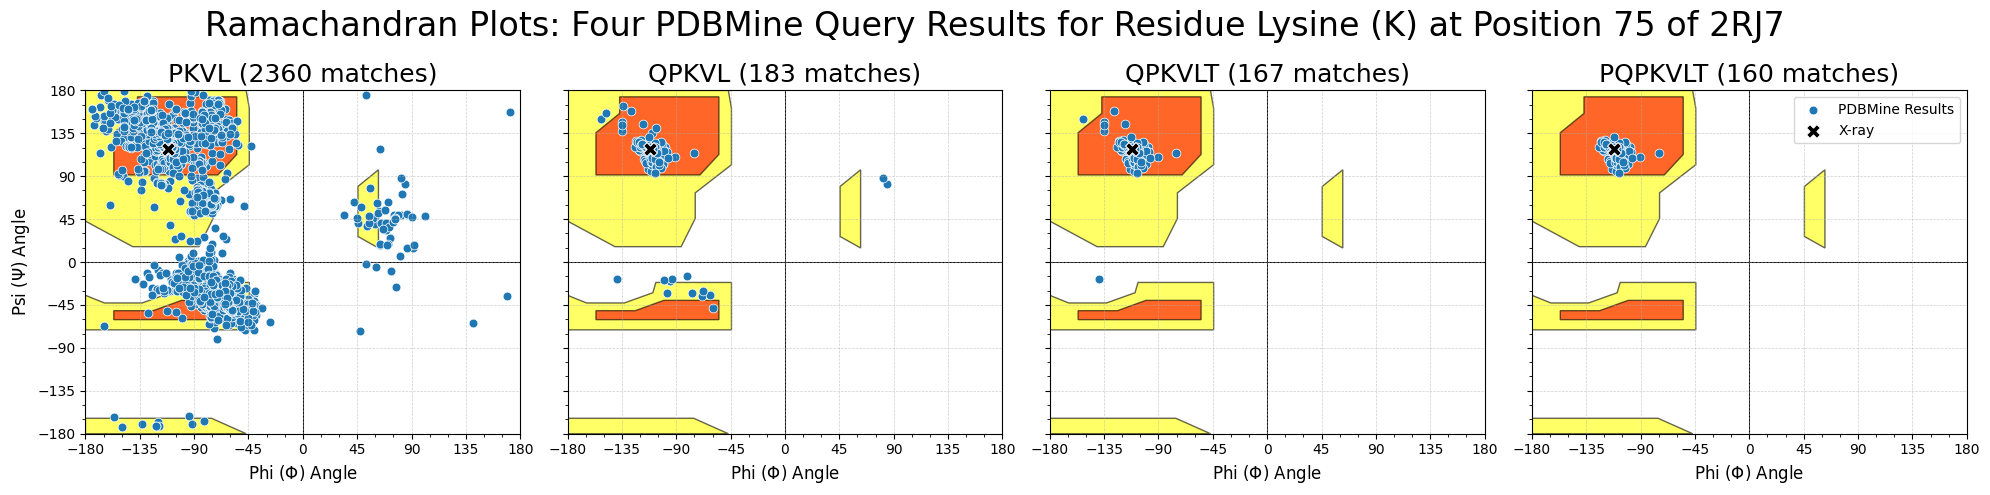

In [32]:
fig, axes = plt.subplots(1, len(da.winsizes), figsize=(20, 5), sharey=True)
for i,(w,ax) in enumerate(zip(da.winsizes, axes)):
    df = phi_psi_dist[phi_psi_dist['winsize'] == w]
    sns.scatterplot(data=df, x='phi', y='psi', ax=ax, alpha=1, s=40, label='PDBMine Results')
    sns.scatterplot(data=xrays, x='phi', y='psi', ax=ax, alpha=1, marker='X', s=100, color='black', label='X-ray')

    plot_ramachandran(ax)


    ax.set_title(f"{results[i][1]} ({results[i][2]} matches)", fontsize=18)
    if w == da.winsizes[0]:
        ax.set_ylabel(r"Psi ($\Psi$) Angle", fontsize=12)

    ax.set_xlabel(r"Phi ($\Phi$) Angle", fontsize=12)

    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)

    ax.set_xticks(np.arange(-180, 181, 15), minor=True)
    ax.set_yticks(np.arange(-180, 181, 15), minor=True)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-180, 181, 45))
    ax.axhline(0, color='black', linewidth=0.75, zorder=0)
    ax.axvline(0, color='black', linewidth=0.75, zorder=0)

    if w == da.winsizes[-1]:
        ax.legend()
    else:
        ax.get_legend().remove()

plt.suptitle(f"Ramachandran Plots: Four PDBMine Query Results for Residue Lysine (K) at Position 75 of 2RJ7", fontsize=24)
plt.tight_layout()
# plt.show()
# plt.savefig('paper_plots/4_ramachandran.pdf', dpi=300)

In [156]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]


Results already exist
Structure exists: 'pdb/pdb7eik.ent' 
UniProt ID: O60885
	Win 5: NKPGD - 753 samples
	Win 6: NKPGDD - 666 samples
	Win 7: YNKPGDD - 660 samples
Number of clusters: 4
(710, 10)
Cluster 0 has 67 members and medoid [ -87.3 -130.   -70.    88.3  -60.3   -2.8   75.1  159.    16.9  147.9]
Cluster 1 has 60 members and medoid [-91.4 -80.5 -56.4 -81.9 -71.5 162.9 144.2 -29.   -4.3 143.4]
Cluster 2 has 563 members and medoid [-104.  -106.1  -53.9   84.7  -61.8  178.5  150.2  138.3  -11.3  148.8]
Cluster 3 has 20 members and medoid [-93.1 -58.1 -47.9 122.1 -84.4 118.3 136.  110.   -0.4 146.9]


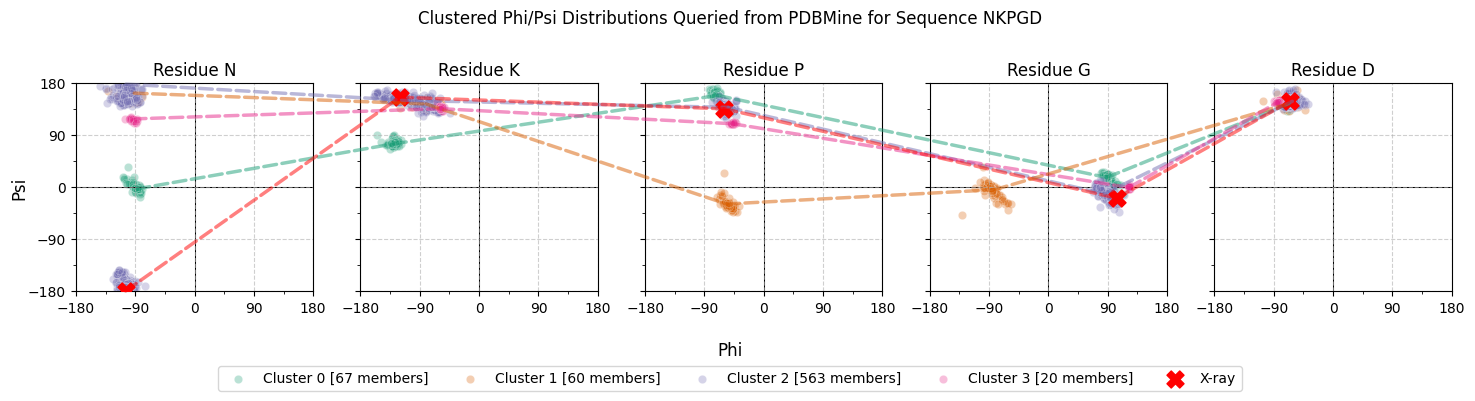

In [ ]:
da = DihedralAdherencePDB('7EIK', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window', kdews=[0,1,0,0])
da.load_results()
da.queries = da.queries[1:]
da.winsizes = da.winsizes[1:]
da.plot_across_window_cluster_medoids('YNKPGDD', verbose=True, mode_scatter=True, plot_xrays=True, cse=30, fn='paper_plots/medoids.pdf')


In [46]:
da = DihedralAdherence(proteins[1], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[0,1,0,0], mode='full_window')
da.load_results()

Initializing T1030 ...
casp_da/T1030_win4-5-6-7
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6


In [ ]:
ins = da
from lib.across_window_utils import get_afs_window, get_xrays_window, get_preds_window, get_combined_phi_psi_dist, precompute_dists, find_clusters, filter_precomputed_dists
MIN_SAMPLES = [100, 20, 1, 1]
MIN_CLUSTER_SIZES = [20, 5, 1, 1]

center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
winsize_ctxt = ins.queries[-1].winsize
seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

n_cluster_results = []
for i,seq_ctxt in enumerate(seqs_for_window):
    print(f'{i}/{len(ins.xray_phi_psi.seq_ctxt.unique())-1}: {seq_ctxt}')
    if 'X' in seq_ctxt:
        print(f'\tSkipping {seq_ctxt} - X in sequence')
        continue

    _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
    for j in info:
        print(f'\tWin {j[0]}: {j[1]} - {j[2]} samples')

    # TODO n_samples

    q = ins.queries[0]
    # xrays = get_xrays_window(ins, q, seq_ctxt)
    # preds = get_preds_window(ins, q, seq_ctxt)
    # afs = get_afs_window(ins, q, seq_ctxt)

    # if xrays.shape[0] != q.winsize*2:
        # print(f"Xray data for {seq_ctxt} is incomplete")
        # continue
    
    phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(ins, seq_ctxt)
    if phi_psi_dist is None or phi_psi_dist.shape[0] == 0:
        print(f"No pdbmine data for {seq_ctxt}")
        continue
    if phi_psi_dist.shape[0] < MIN_SAMPLES[0]:
        print(f"Not enough pdbmine data for {seq_ctxt}")
        continue

    precomputed_dists = precompute_dists(phi_psi_dist_v)
    n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
    if n_clusters == 0:
        print(f"No clusters found for {seq_ctxt}")
        continue
    n_cluster_results.append((info[0][2], n_clusters))

In [48]:
n_cluster_results = pd.DataFrame(n_cluster_results, columns=['n_samples', 'n_clusters'])

In [45]:
n_cluster_results_4 = n_cluster_results

# 500 samples

In [ ]:
pdb_codes_2 = [d.name.split('_')[0] for d in Path(PROJECT_DIR).iterdir()]

In [93]:
win7_proteins = pd.read_csv('win7-clusters-1000.csv')['protein'].unique()
# win7_proteins = pd.read_csv('win6-clusters-1000.csv')['protein'].unique()
pdb_codes_2 = np.setdiff1d(np.array(pdb_codes_2), win7_proteins)

In [28]:
seqs_per_protein = 8
samples = np.random.choice(pdb_codes_2, 600 // seqs_per_protein, replace=False)

In [5]:
from lib.across_window_utils import get_combined_phi_psi_dist, precompute_dists, find_clusters, filter_precomputed_dists
from lib.utils import get_phi_psi_dist
def get_n_clusters(ins, k):
    MIN_SAMPLES = [100, 20, 5, 5]
    MIN_CLUSTER_SIZES = [20, 5, 1, 1]

    center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
    winsize_ctxt = ins.queries[-1].winsize
    seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

    seq_ctxt = None
    n_skipped = 0
    while seq_ctxt is None:
        if n_skipped > 30:
            print(f"Skipping {da.pdb_code}")
            return None, None, None, None
        n_skipped += 1
        seq_ctxt = np.random.choice(seqs_for_window, 1)[0]
        if 'X' in seq_ctxt:
            print(f'\tSkipping {seq_ctxt} - X in sequence')
            seq_ctxt = None
            continue
        phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(ins, seq_ctxt)
        if phi_psi_dist is None or phi_psi_dist.shape[0] == 0:
            print(f"No pdbmine data for {seq_ctxt}")
            seq_ctxt = None
            continue
        if phi_psi_dist.shape[0] < MIN_SAMPLES[k]:
            print(f"Not enough pdbmine data for {seq_ctxt} ({phi_psi_dist.shape[0]})")
            seq_ctxt = None
            continue
    if phi_psi_dist.shape[0] > 2500:
        phi_psi_dist = phi_psi_dist.sample(2500)
    _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
    print(f'\tWin {info[k][0]}: {info[k][1]} - {info[k][2]} samples')
    precomputed_dists = precompute_dists(phi_psi_dist_v)
    n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
    return da.pdb_code, seq_ctxt, info[k][2], n_clusters

In [ ]:
results = []
n_skipped = 0
k=3
kdews = [0, 0, 0, 0]
kdews[k] = 1
# for i,sample in enumerate(samples):
for i,sample in enumerate(['7YYX']):
    print(f'{i}/{len(samples)-1}: {sample}')
    da = DihedralAdherencePDB(
        sample, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window',
        kdews=kdews
    )
    if (not da.has_af or
        len([d for d in da.outdir.iterdir()]) == 0 or 
        not (da.outdir / 'xray_phi_psi.csv').exists()
    ):
        n_skipped += 1
        continue
    if not da.load_results():
        n_skipped += 1
        continue
    if da.xray_phi_psi.shape[0] == 0 or len(da.seqs) <= 6:
        n_skipped += 1
        continue
    for i in range(seqs_per_protein):
        ret = get_n_clusters(da, k)
        if ret[0] is None:
            n_skipped += 1
            break
        results.append(ret)
results = pd.DataFrame(results, columns = ['protein', 'seq_ctxt', 'n_samples', 'n_clusters'])

0/74: 7YYX
Results already exist
Structure exists: 'pdb/pdb7yyx.ent' 


No UniProt mapping found for 7YYX


In [ ]:
least_len = min(
    pd.read_csv('win4-clusters-3000.csv').shape[0],
    pd.read_csv('win5-clusters-3000.csv').shape[0],
    pd.read_csv('win6-clusters-3000.csv').shape[0],
    pd.read_csv('win7-clusters-3000.csv').shape[0]
)

In [21]:
least_len = 2700

In [27]:
results

,protein,seq_ctxt,n_samples,n_clusters
779,3KFF,NIIDLTK,3210,17
1931,7X9J,GEPWGKE,689,7
1837,2ZBQ,RALLTGI,6063,26
66,1HK4,LLFFAKR,1550,8
2167,5FSO,GTPVESD,1690,19
...,...,...,...,...
865,3SCY,GSGPRHL,615,7
1484,2AMN,IAGYNLY,1967,20
1129,7EAR,NDSFNYW,927,13
589,8R9E,IAAKYKE,1942,14


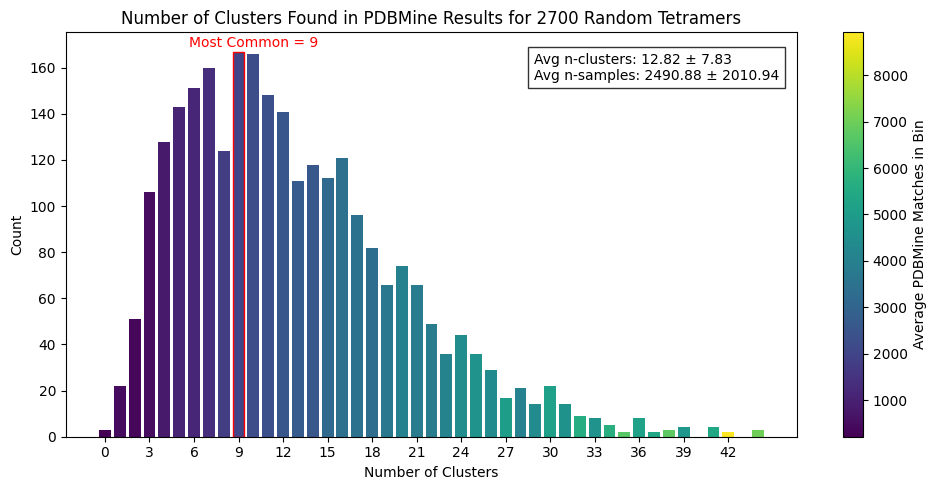

In [33]:
results = pd.read_csv('win4-clusters-3000.csv').sample(least_len)
results = results[results['n_samples'] < results['n_samples'].quantile(0.999)]
grouped = results.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()

grouped = grouped[grouped['count'] > grouped['count'].quantile(0.01)]

norm = plt.Normalize(grouped['n_samples'].min(), grouped['n_samples'].max())
colors = plt.cm.viridis(norm(grouped['n_samples']))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(grouped['n_clusters'], grouped['count'], color=colors)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Average PDBMine Matches in Bin')

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Count')
ax.set_title('Number of Clusters Found in PDBMine Results for 2700 Random Tetramers')

ax.set_xticks(np.arange(0, grouped['n_clusters'].max(), 3))

avg_clusters = results['n_clusters'].mean()
std_clusters = results['n_clusters'].std()
avg_samples = results['n_samples'].mean()
std_samples = results['n_samples'].std()

# Add text annotations for averages and standard deviations
text_str = (f'Avg n-clusters: {avg_clusters:.2f} ± {std_clusters:.2f}\n'
            f'Avg n-samples: {avg_samples:.2f} ± {std_samples:.2f}')
ax.text(0.64, 0.95, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8))

most_common = grouped.loc[grouped['count'].idxmax(), 'n_clusters']
highlight_index = grouped[grouped['n_clusters'] == most_common].index
if not highlight_index.empty:
    bars[highlight_index[0]].set_edgecolor('red')
    bars[highlight_index[0]].set_linewidth(1)
    ax.text(10, grouped.loc[highlight_index[0], 'count']+0.5, f'Most Common = {most_common}',
            ha='center', va='bottom', color='red', fontsize=10)
    
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/n_clusters-4.pdf', dpi=300)

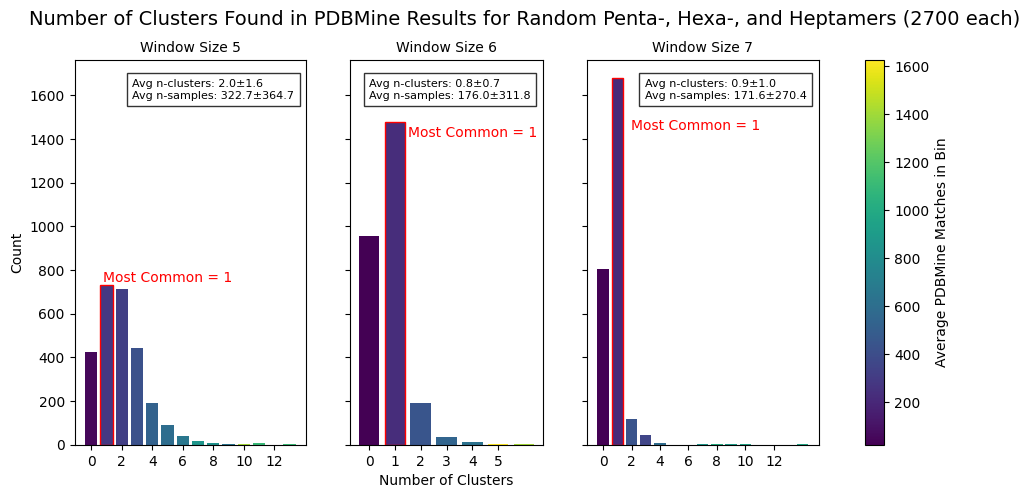

In [35]:
results5 = pd.read_csv('win5-clusters-3000.csv').sample(least_len)
results6 = pd.read_csv('win6-clusters-3000.csv').sample(least_len)
results7 = pd.read_csv('win7-clusters-3000.csv').sample(least_len)

results5 = results5[results5['n_samples'] < results5['n_samples'].quantile(0.99)]
results6 = results6[results6['n_samples'] < results6['n_samples'].quantile(0.99)]
results7 = results7[results7['n_samples'] < results7['n_samples'].quantile(0.99)]

grouped5 = results5.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()
grouped6 = results6.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()
grouped7 = results7.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()
grouped5 = grouped5[grouped5['count'] > grouped5['count'].quantile(0.01)]
grouped6 = grouped6[grouped6['count'] > grouped6['count'].quantile(0.01)]
grouped7 = grouped7[grouped7['count'] > grouped7['count'].quantile(0.01)]

all_samples = pd.concat([grouped5, grouped6, grouped7], axis=0)['n_samples']
norm = plt.Normalize(all_samples.min(), all_samples.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1.2, 1, 1.2]})
text_adj = [(5,0),(4,80),(6.5,250)]
stats_adj = [0.25, 0.1, 0.25]
results = [results5, results6, results7]
for i, (grouped, ax) in enumerate(zip([grouped5, grouped6, grouped7], axes)):
    colors = plt.cm.viridis(norm(grouped['n_samples']))

    bars = ax.bar(grouped['n_clusters'], grouped['count'], color=colors)
        
    ax.set_xticks(np.arange(0, grouped['n_clusters'].max(), (1 if i == 1 else 2)))
    ax.set_title(f'Window Size {i+5}', fontsize=10)
    

    avg_clusters = results[i]['n_clusters'].mean()
    std_clusters = results[i]['n_clusters'].std()
    avg_samples = results[i]['n_samples'].mean()
    std_samples = results[i]['n_samples'].std()

    text_str = (f'Avg n-clusters: {avg_clusters:.1f}±{std_clusters:.1f}\n'
                f'Avg n-samples: {avg_samples:.1f}±{std_samples:.1f}')
    ax.text(stats_adj[i], 0.95, text_str, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.8))

    most_common = grouped.loc[grouped['count'].idxmax(), 'n_clusters']
    highlight_index = grouped[grouped['n_clusters'] == most_common].index
    if not highlight_index.empty:
        bars[highlight_index[0]].set_edgecolor('red')
        bars[highlight_index[0]].set_linewidth(1)
        ax.text(text_adj[i][0], grouped.loc[highlight_index[0], 'count']-text_adj[i][1], f'Most Common = {most_common}',
                ha='center', va='bottom', color='red', fontsize=10)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, label='Average PDBMine Matches in Bin')
plt.suptitle('Number of Clusters Found in PDBMine Results for Random Penta-, Hexa-, and Heptamers (2700 each)', fontsize=14)

axes[1].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Count')

# plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/n_clusters-567.pdf', dpi=300)